In [1]:
#Importamos librerias base
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

#Importamos el modelo de clasificación y las métricas
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#Para la visualización
import graphviz 
import pydotplus
from IPython.display import Image

In [20]:
#Traemos el DataFrame
data = pd.read_csv('PVR_train_test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CantidadNum                       805 non-null    float64
 1   desocupados                       805 non-null    float64
 2   0-14                              805 non-null    float64
 3   65_mas                            805 non-null    float64
 4   hacinamiento                      805 non-null    float64
 5   densidad_comercios                805 non-null    float64
 6   Target_NoApto                     805 non-null    int64  
 7   TipoResiduo_Papel                 805 non-null    int64  
 8   TipoResiduo_Plástico              805 non-null    int64  
 9   TipoResiduo_Vidrio, Metal, Tetra  805 non-null    int64  
 10  punto_tipo_Rulero                 805 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 69.3 KB


In [21]:
#Generamos el x y el target

X= data.drop(['Target_NoApto'], axis = 1)
y= data['Target_NoApto']

In [22]:
#Hacemos el train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, stratify=y, random_state= 99)

#Resultados
print('Chequeamos tamaños:')
print('')
print('Tamaño del train:', X_train.shape, y_train.shape, 'En %: ', X_train.shape[0]/X.shape[0])
print('Tamaño del test: ', X_test.shape, y_test.shape, 'En %: ', X_test.shape[0]/X.shape[0] )
print('')
print('Chequeamos stratify:')
print('')
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

Chequeamos tamaños:

Tamaño del train: (603, 10) (603,) En %:  0.7490683229813665
Tamaño del test:  (202, 10) (202,) En %:  0.25093167701863356

Chequeamos stratify:

1    0.693201
0    0.306799
Name: Target_NoApto, dtype: float64
1    0.693069
0    0.306931
Name: Target_NoApto, dtype: float64


In [7]:
#Reescalamos la variable X
#Scaler = MinMaxScaler()
#X_train = Scaler.fit_transform(X_train)
#X_test = Scaler.fit_transform(X_test)

Quizás podemos utilizar las herramientas de undersampling / oversampling para homogeneizar las etiquetas

In [49]:
#Inicializamos el modelo
clftree = tree.DecisionTreeClassifier()

In [50]:
#Hagamos un GridSearch con esta grilla
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,None],
                "min_samples_split": [2, 3, 4,None]}

In [51]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-1, scoring='accuracy', cv= 10)

In [52]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [53]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [54]:
cv_clf = grid_search.best_estimator_
cv_clf

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20)

In [55]:
pd.DataFrame({'atributo':X.columns, 'importancia':cv_clf.feature_importances_}).sort_values('importancia', ascending = False)

,atributo,importancia
0,CantidadNum,0.726363
2,0-14,0.116721
6,TipoResiduo_Papel,0.070804
8,"TipoResiduo_Vidrio, Metal, Tetra",0.050357
9,punto_tipo_Rulero,0.028655
3,65_mas,0.007101
1,desocupados,0.000000
4,hacinamiento,0.000000
5,densidad_comercios,0.000000
7,TipoResiduo_Plástico,0.000000


In [56]:
#Score para el test
accuracy_score(y_test, cv_clf.predict(X_test))

0.7128712871287128

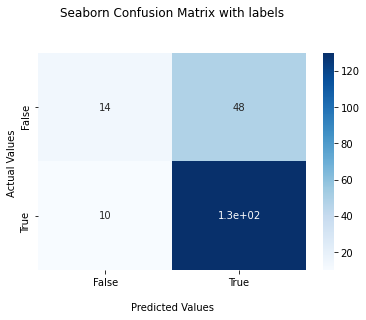

In [57]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, cv_clf.predict(X_test))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

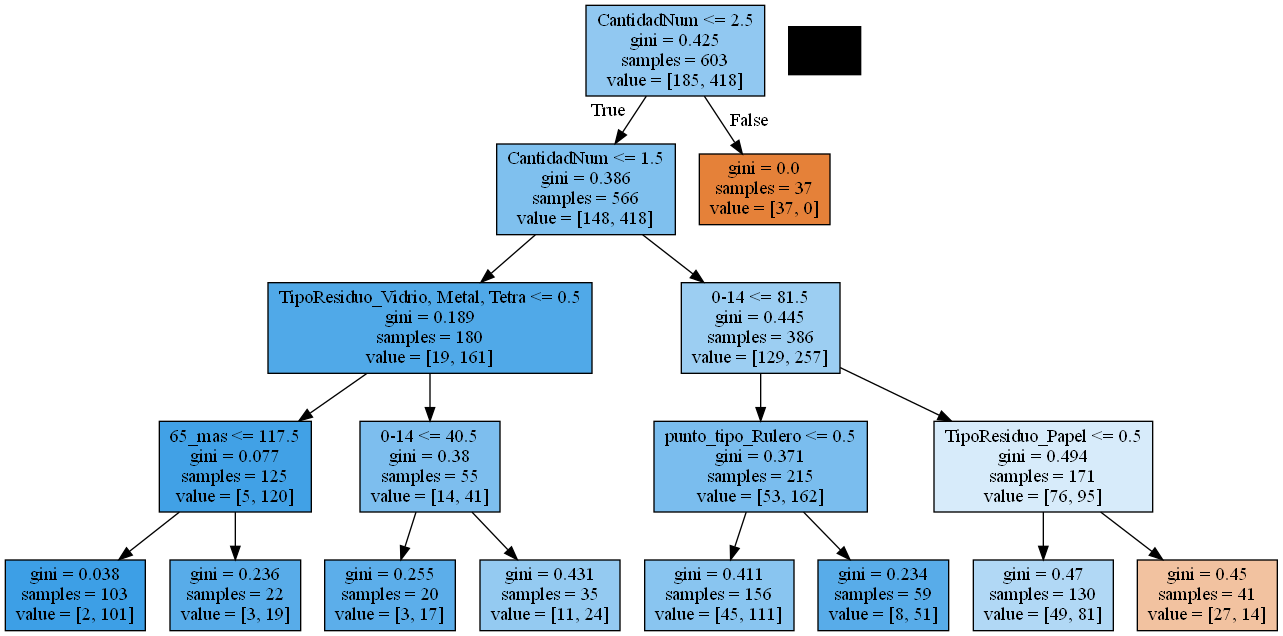

In [58]:
#Visualizamos el árbol
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= X.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

Oversampling con SMOTE

In [2]:
#Traemos el DataFrame sin dummies
data_sindummies = pd.read_csv('PVR_train_test_sindummies.csv')

In [3]:
data_sindummies

,Target,TipoResiduo,CantidadNum,punto_tipo,desocupados,0-14,65_mas,hacinamiento,densidad_comercios
0,Apto,Papel,2.0,Punto verde,17.0,101.0,103.0,1.0,7.0
1,Apto,"Vidrio, Metal, Tetra",2.0,Punto verde,17.0,101.0,103.0,1.0,7.0
2,Apto,Plástico,2.0,Punto verde,17.0,101.0,103.0,1.0,7.0
3,Apto,Papel,3.0,Punto verde,38.0,161.0,145.0,1.0,17.0
4,Apto,"Vidrio, Metal, Tetra",3.0,Punto verde,38.0,161.0,145.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
800,NoApto,PET,1.0,Rulero,11.0,87.0,102.0,0.0,10.0
801,NoApto,PET,1.0,Rulero,11.0,87.0,102.0,0.0,10.0
802,NoApto,PET,1.0,Rulero,11.0,87.0,102.0,0.0,10.0
803,NoApto,PET,1.0,Rulero,11.0,87.0,102.0,0.0,10.0


In [24]:
#Hacemos el train_test_split con las variables categóricas
X_train_cat, X_test_cat, y_train, y_test = train_test_split(data_sindummies.drop('Target', axis=1), data_sindummies['Target'], stratify = data_sindummies['Target']
                                                           ,random_state= 99)

In [5]:
from imblearn.over_sampling import SMOTENC

In [25]:
categorical_cols=(X_train_cat.dtypes=='object').values
numerical_cols= ~categorical_cols

sm=SMOTENC(categorical_features=categorical_cols,k_neighbors=5,random_state=0)
X_train_sm,y_train_sm=sm.fit_resample(X_train_cat,y_train)

In [26]:
print('Balance de clases:')
print(y_train_sm.value_counts(normalize=False))

Balance de clases:
Apto      418
NoApto    418
Name: Target, dtype: int64


In [27]:
enc=OneHotEncoder(drop='first',sparse=False)
train_dummies=enc.fit_transform(X_train_sm.loc[:,categorical_cols])
train_dummies=pd.DataFrame(train_dummies)
train_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]

X_train_final=X_train_sm.loc[:,numerical_cols].join(train_dummies)

test_dummies=enc.transform(X_test_cat.loc[:,categorical_cols])
test_dummies=pd.DataFrame(test_dummies)
test_dummies.columns=[x for cat_list in enc.categories_ for x in cat_list[1:]]
test_dummies.index=X_test.index

X_test_final=X_test_cat.loc[:,numerical_cols].join(test_dummies)

print(X_train_final.shape)
print(X_test_final.shape)

(836, 10)
(202, 10)


In [28]:
grid_search.fit(X_train_final, y_train_sm)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [29]:
cv_clf_os = grid_search.best_estimator_
cv_clf_os

DecisionTreeClassifier(max_depth=14, min_samples_leaf=5)

In [31]:
#Score para el test
accuracy_score(y_test, cv_clf_os.predict(X_test_final))

0.6237623762376238

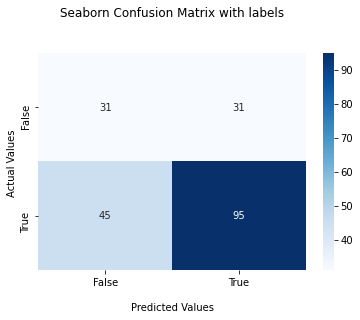

In [37]:
#Matriz de confusion
cf_matrix= confusion_matrix(y_test, cv_clf_os.predict(X_test_final))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

OVERSAMPLING DONT GIVE GOOD RESULTS!

In [70]:
#Importamos
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

Random Forest

In [71]:
#Instanciamos el modelo y ajustamos los datos 
rf_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [72]:
#Vemos accuracy y matriz de confusión
print(confusion_matrix(y_test, rf_clf.predict(X_test)))
print('')
print('The Random Forest score is: ', accuracy_score(y_test, rf_clf.predict(X_test)))

[[ 21  41]
 [ 28 112]]

The Random Forest score is:  0.6584158415841584


Bagging 

In [73]:
bag_clf = BaggingClassifier(base_estimator=clftree, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, random_state=42)

In [74]:
print(confusion_matrix(y_test, bag_clf.predict(X_test)))
print('')
print('The Bagging score is: ', accuracy_score(y_test, bag_clf.predict(X_test)))

[[ 21  41]
 [ 23 117]]

The Bagging score is:  0.6831683168316832


AdaBoost

In [76]:
AdaBoost = AdaBoostClassifier (
           tree.DecisionTreeClassifier(max_depth=1), n_estimators= 1000
)

AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=1000)

In [77]:
predictions = AdaBoost.predict(X_test)

In [78]:
print(confusion_matrix(y_test, predictions))
print('')
print('The AdaBoost score is: ', accuracy_score(y_test, predictions))

[[ 21  41]
 [ 11 129]]

The AdaBoost score is:  0.7425742574257426


Gradient Boosting

In [79]:
parameters = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

In [80]:
GB_clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

In [81]:
GB_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]})

In [82]:
print(GB_clf.best_params_)
print('The Gradient Boosting score is: ', accuracy_score(y_test, GB_clf.predict(X_test)))

{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000}
The Gradient Boosting score is:  0.7277227722772277
